<a href="https://colab.research.google.com/github/danbev/learning-ai/blob/main/lora/python/src/lora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers accelerate evaluate datasets peft -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:00:00


In [2]:
import transformers
import accelerate
import peft

print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")
print(f"PEFT version: {peft.__version__}")
"Transformers version: 4.27.4"
"Accelerate version: 0.18.0"
"PEFT version: 0.2.0"

Transformers version: 4.33.2
Accelerate version: 0.23.0
PEFT version: 0.5.0


'PEFT version: 0.2.0'

In [5]:
from huggingface_hub import notebook_login

notebook_login()

In [6]:
model_checkpoint = "google/vit-base-patch16-224-in21k"

In [7]:
from datasets import load_dataset

dataset = load_dataset("food101", split="train[:5000]")

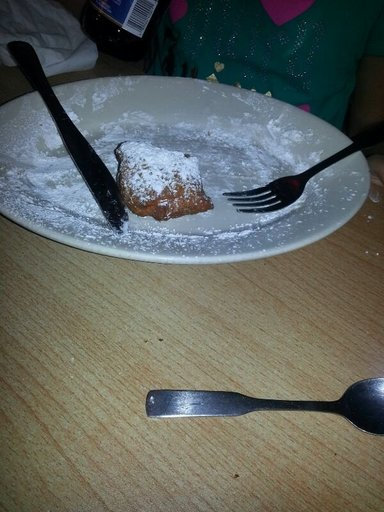

In [8]:
from IPython.display import Image
dataset[0]["image"]

In [9]:
labels = dataset.features["label"].names
labels

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [10]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)

In [11]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

In [12]:
from transformers import TrainingArguments, Trainer


model_name = model_checkpoint.split("/")[-1]
batch_size = 128

args = TrainingArguments(
    f"{model_name}-finetuned-lora-food101",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-3,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    num_train_epochs=5,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    label_names=["labels"],
)

In [13]:
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
train_transforms = Compose(
    [
        RandomResizedCrop(image_processor.size["height"]),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)

val_transforms = Compose(
    [
        Resize(image_processor.size["height"]),
        CenterCrop(image_processor.size["height"]),
        ToTensor(),
        normalize,
    ]
)


def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [train_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch


def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [14]:
splits = dataset.train_test_split(test_size=0.1)
train_ds = splits["train"]
val_ds = splits["test"]

In [15]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [17]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [18]:
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[9]

'breakfast_burrito'

In [19]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
print_trainable_parameters(model)

trainable params: 85876325 || all params: 85876325 || trainable%: 100.00


In [21]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

trainable params: 745162 || all params: 86543818 || trainable%: 0.86


In [22]:
from transformers import TrainingArguments, Trainer


model_name = model_checkpoint.split("/")[-1]
batch_size = 128

args = TrainingArguments(
    f"{model_name}-finetuned-lora-food101",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-3,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    num_train_epochs=5,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    label_names=["labels"],
)

In [23]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [24]:
import torch


def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [25]:
trainer = Trainer(
    lora_model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.591147,0.852000
2,2.197300,0.214142,0.938000
3,0.353500,0.159460,0.946000
4,0.210700,0.139086,0.952000
5,0.187700,0.138858,0.952000


In [26]:
trainer.evaluate(val_ds)

{'eval_loss': 0.13908644020557404,
 'eval_accuracy': 0.952,
 'eval_runtime': 2.9185,
 'eval_samples_per_second': 171.321,
 'eval_steps_per_second': 1.371,
 'epoch': 5.0}

In [30]:
repo_name = f"danbev/{model_name}-finetuned-lora-food101"
repo_name
lora_model.push_to_hub(repo_name)

CommitInfo(commit_url='https://huggingface.co/danbev/vit-base-patch16-224-in21k-finetuned-lora-food101/commit/c04d23b336d40b971228f22493f5d46eddfdc857', commit_message='Upload model', commit_description='', oid='c04d23b336d40b971228f22493f5d46eddfdc857', pr_url=None, pr_revision=None, pr_num=None)

In [31]:
from peft import PeftConfig, PeftModel


config = PeftConfig.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(
    config.base_model_name_or_path,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)
# Load the LoRA model
inference_model = PeftModel.from_pretrained(model, repo_name)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


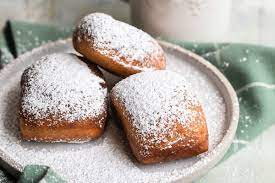

In [32]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/beignets.jpeg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [35]:
image_processor = AutoImageProcessor.from_pretrained(repo_name)
encoding = image_processor(image.convert("RGB"), return_tensors="pt")
encoding

{'pixel_values': tensor([[[[ 0.4588,  0.4588,  0.4667,  ...,  0.8980,  0.8902,  0.8902],
          [ 0.4667,  0.4667,  0.4745,  ...,  0.8980,  0.8902,  0.8902],
          [ 0.4902,  0.4902,  0.4980,  ...,  0.8980,  0.8902,  0.8902],
          ...,
          [ 0.2235, -0.2706, -0.4431,  ...,  0.7490,  0.7569,  0.7569],
          [-0.1294, -0.3490, -0.3961,  ...,  0.7490,  0.7490,  0.7490],
          [-0.1686, -0.3647, -0.0980,  ...,  0.7490,  0.7412,  0.7412]],

         [[ 0.4745,  0.4745,  0.4824,  ...,  0.8980,  0.8902,  0.8902],
          [ 0.4824,  0.4824,  0.4902,  ...,  0.8980,  0.8902,  0.8902],
          [ 0.4980,  0.4980,  0.5059,  ...,  0.8980,  0.8902,  0.8902],
          ...,
          [ 0.2941, -0.2078, -0.3961,  ...,  0.7725,  0.7647,  0.7647],
          [-0.0588, -0.2863, -0.3490,  ...,  0.7647,  0.7569,  0.7569],
          [-0.0980, -0.3020, -0.0510,  ...,  0.7647,  0.7490,  0.7490]],

         [[ 0.4510,  0.4510,  0.4588,  ...,  0.8824,  0.8745,  0.8745],
          [ 0

In [36]:
with torch.no_grad():
    outputs = inference_model(**encoding)
    logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", inference_model.config.id2label[predicted_class_idx])

Predicted class: beignets
